# Library Gate Counts
#### This working with visualization and processing with the library gate counts.

In [1]:
import pandas as pd
import numpy as np

Changing the data input to include all gate counts.

In [2]:
gateCounts = pd.read_csv(r'../data/FullGateCounts.csv')

In [3]:
gateCounts.head()

,date,CG-OPEN,CG-CLOSE,CON-OPEN,CON-CLOSE
0,7/1/2010,258496.0,259594.0,693996.0,695730.0
1,7/2/2010,259618.0,260250.0,695744.0,696834.0
2,7/3/2010,260252.0,260374.0,696836.0,696970.0
3,7/4/2010,260374.0,260374.0,696970.0,696970.0
4,7/5/2010,260734.0,260734.0,696970.0,696970.0


In [4]:
gateCounts['date'] = gateCounts['date'].apply(pd.to_datetime)

- The gate counts are taken twice a day, once at open and once at close.
- Jackson Library: College Avenue entrance (CLG)
- Jackson Library: EUC Connector entrance (CON)

A gate number increases by one if a person regardless of the direction traveled. The calculation below is based upon the average of the differences between the numbers at open and at close.



In [5]:
gateCounts['Patrons'] =\
((gateCounts['CG-CLOSE'] - gateCounts['CG-OPEN']) + (gateCounts['CON-CLOSE'] - gateCounts['CON-OPEN']))/2
gateCounts.head()

,date,CG-OPEN,CG-CLOSE,CON-OPEN,CON-CLOSE,Patrons
0,2010-07-01,258496.0,259594.0,693996.0,695730.0,1416.0
1,2010-07-02,259618.0,260250.0,695744.0,696834.0,861.0
2,2010-07-03,260252.0,260374.0,696836.0,696970.0,128.0
3,2010-07-04,260374.0,260374.0,696970.0,696970.0,0.0
4,2010-07-05,260734.0,260734.0,696970.0,696970.0,0.0


In [6]:
gateCounts.iloc[1,0]

Timestamp('2010-07-02 00:00:00')

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

manually mapping colors to days

In [8]:
dayColors = [
    'red',
    'orange',
    'yellow',
    'green',
    'blue',
    'indigo',
    'violet'
    ]
#Rotating the colors to get the rainbow to appear correctly.
dayColors = dayColors[5:]+ dayColors[:5]

In [9]:
import calendar

Some interesting correlations to the visuals below:
- 01/17/17: Classes begin
- 03/11/17: Spring Break begins
- 03/20/17: Spring Break ends
- 05/03/17: Reading day
- 05/04/17: Finals start
- 05/12/17: Commencement

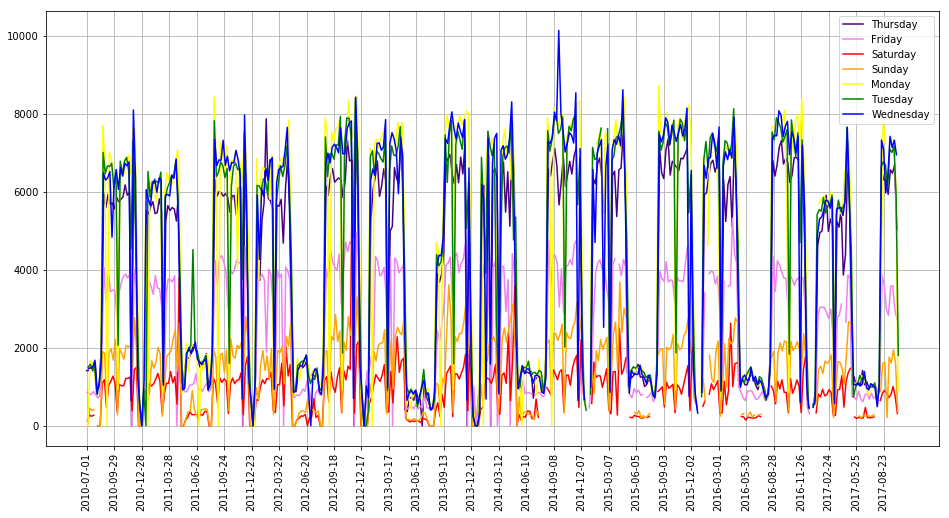

In [10]:
plt.figure(figsize=(16,8))
plt.grid(b=True)
plt.xticks(gateCounts.index.values[::90], gateCounts.date.dt.strftime("%Y-%m-%d")[::90], rotation=90)
for i in range(7):
    plt.plot(gateCounts.index.values[i::7],gateCounts['Patrons'][i::7].values,\
                c=dayColors[i],\
                label=calendar.day_name[gateCounts.iloc[i,0].weekday()]);
plt.legend();

### Correlating gate count to weather.

Concatenating full weather data together:

In [11]:
weatherData = pd.concat([
    pd.read_csv(r'../data/1101311.csv',low_memory=False,usecols =['DATE','HOURLYWETBULBTEMPF','HOURLYPrecip']),
    pd.read_csv(r'../data/1052640.csv',low_memory=False,usecols =['DATE','HOURLYWETBULBTEMPF','HOURLYPrecip'])],
    axis=0)

In [12]:
weatherData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100011 entries, 0 to 8909
Data columns (total 3 columns):
DATE                  100011 non-null object
HOURLYWETBULBTEMPF    96296 non-null float64
HOURLYPrecip          68151 non-null object
dtypes: float64(1), object(2)
memory usage: 3.1+ MB


In [13]:
weatherData['DATE'] = weatherData['DATE'].apply(pd.to_datetime)

The unique values here show that there might be some suspect data. (See issue 21 for details)

In [14]:
weatherData.iloc[:,2].unique()

array([nan, '0.00', 'T', '0.06', '0.07', '0.08', '0.01', '0.04s', '0.13',
       '0.05', '0.29', '0.68', '0.84', '0.85', '0.02', '0.12', '0.71',
       '1.47', '1.78', '0.43', '0.04', '0.11', '0.03', '0.20', '0.24',
       '0.27', '0.45s', '0.86', '0.98', '1.02', '1.29', '1.19', '0.30',
       '0.34', '0.33', '0.09', '0.19', '0.21', '0.25', '0.26', '0.17',
       '0.41', '0.73', '1.06', '1.08', '0.18', '0.23', '0.44', '0.14',
       '1.34', '0.37', '0.38', '0.28', '0.10', '0.05s', '0.25s', '0.32',
       '0.52', '0.55', '0.50', '0.22', '0.31', '0.39', '0.40', '0.47',
       '0.48', '0.54', '0.57', '0.64', '0.81', '0.80', '0.15', '0.03s',
       '0.42', '0.45', '0.02s', '0.09s', '0.16', '0.65', '1.05', '1.04',
       '0.08s', '0.07s', '0.06s', '0.36', '0.26s', '0.75', '0.78', '0.66',
       '0.67', '0.82', '0.63', '0.16s', '0.10s', '0.01s', '0.60', '0.72',
       '1.27', '0.51', '0.35', '0.89', '0.56', '0.97', '1.03', '0.93',
       '0.46', '0.12s', '0.70', '0.79', '0.58', '1.15', '0.94

Creating a custom function to convert the values to numbers. `pd.to_numeric()` might work, but would prefer to convert the 'T' to a 0.001 to indicate trace amounts of precipitation. Also, values with an s would be converted to non-numeric.

In [15]:
def precipConvert(val):
    if str(val)[-1] == 's':
        return float(val[:-1])
    elif val == 'T':
        return 0.001
    else:
        return val

The temperatures here seem to be ok without transformation.

In [16]:
weatherData['HOURLYWETBULBTEMPF'].unique()

array([ 68.,  67.,  66.,  63.,  64.,  65.,  61.,  62.,  60.,  nan,  59.,
        57.,  54.,  58.,  56.,  55.,  69.,  70.,  71.,  72.,  73.,  74.,
        75.,  76.,  77.,  78.,  79.,  80.,  53.,  52.,  51.,  50.,  49.,
        48.,  47.,  46.,  45.,  43.,  42.,  44.,  41.,  40.,  38.,  37.,
        36.,  39.,  35.,  34.,  32.,  31.,  30.,  28.,  27.,  29.,  33.,
        26.,  25.,  24.,  22.,  23.,  21.,  20.,  19.,  18.,  17.,  16.,
        15.,  14.,  13.,  12.,  11.,   9.,   8.,   7.,   6.,   5.,   4.,
         3.,  10.,  82.,  81.,  83.])

In [17]:
precipFormatted = weatherData['HOURLYPrecip'].apply(precipConvert).apply(pd.to_numeric)

In [18]:
pd.concat([gateCounts['Patrons'],gateCounts['Patrons'].rolling(7).mean()],axis=1).head(10)

,Patrons,Patrons
0,1416.0,NaN
1,861.0,NaN
2,128.0,NaN
3,0.0,NaN
4,0.0,NaN
5,1505.0,NaN
6,1473.0,769.000000
7,1417.0,769.142857
8,824.0,763.857143
9,280.0,785.571429


In [19]:
weatherDates = np.array(weatherData['DATE'], dtype=np.datetime64)
gateDates = np.array(gateCounts['date'], dtype=np.datetime64)

Testing correlative data with bokeh example code.
from http://bokeh.pydata.org/en/0.11.1/docs/user_guide/quickstart.html

In [20]:
from bokeh.plotting import figure, output_file, show, output_notebook
from bokeh.models import LinearAxis, Range1d

In [21]:
#output_file("library_weather.html", title="Weather and Gate Counts in Jackson Library")
output_notebook()
p = figure(width=800, height=350, x_axis_type="datetime",toolbar_location='above')

Loading BokehJS ...

In [22]:
p.extra_y_ranges['Temp'] = Range1d(0, 100)
p.add_layout(LinearAxis(y_range_name="Temp"), 'right')
p.line(weatherDates,weatherData['HOURLYWETBULBTEMPF'].values,legend='Temp in F',y_range_name="Temp")
p.line(gateDates,gateCounts['Patrons'],legend="Gate Count", color='green')
# p.circle(weatherDates,precipFormatted * 1000,color='blue',alpha=0.2, legend='Precipitation')
# p.circle(gateDates, gateCounts['Patrons'].values, color='red', legend='Gate Count')
#p.title = "Library Gate Counts vs. Weather"
p.legend.location = "top_left"
p.grid.grid_line_alpha=0
p.xaxis.axis_label = 'Date'
#p.yaxis.axis_label = 'Gate Count'
p.ygrid.band_fill_color="gray"
p.ygrid.band_fill_alpha = 0.1


This graph is not formatted correctly, but it does show how the functionality might work.

In [23]:
show(p)

There appear to be some pockets of missing data. Checking between some arbitrary dates to investigate.

In [32]:
startDate = pd.to_datetime("2014-07-01")
endDate = pd.to_datetime("2014-07-10")
dateMask = (gateCounts.date > startDate) & (gateCounts.date < endDate)
gateCounts[dateMask]

,date,CG-OPEN,CG-CLOSE,CON-OPEN,CON-CLOSE,Patrons
1462,2014-07-02,631932.0,632768.0,448932.0,450274.0,1089.0
1463,2014-07-03,632768.0,633276.0,450274.0,451184.0,709.0
1464,2014-07-04,NaN,0.0,NaN,0.0,NaN
1465,2014-07-05,633276.0,633392.0,451184.0,451424.0,178.0
1466,2014-07-06,633392.0,633530.0,451424.0,451594.0,154.0
1467,2014-07-07,633530.0,634560.0,451594.0,453104.0,1270.0
1468,2014-07-08,634560.0,635610.0,453104.0,454792.0,1369.0
1469,2014-07-09,635610.0,636616.0,454792.0,456358.0,1286.0


It appears to be the function of mean when `np.nan` is involved.

In [37]:
testNums = [np.nan,3.0,3.0,2.0,5.0,0]

In [39]:
print np.mean(testNums)
print np.mean(testNums[1:])
print np.mean(testNums[1:-1])

nan
2.6
3.25


### More interactions between weather and gate count:

In [25]:
gateCounts.head()

,date,CG-OPEN,CG-CLOSE,CON-OPEN,CON-CLOSE,Patrons
0,2010-07-01,258496.0,259594.0,693996.0,695730.0,1416.0
1,2010-07-02,259618.0,260250.0,695744.0,696834.0,861.0
2,2010-07-03,260252.0,260374.0,696836.0,696970.0,128.0
3,2010-07-04,260374.0,260374.0,696970.0,696970.0,0.0
4,2010-07-05,260734.0,260734.0,696970.0,696970.0,0.0


In [26]:
dailyTempMin = weatherData.set_index('DATE').groupby(pd.TimeGrouper('D'))['HOURLYWETBULBTEMPF'].min()
dailyTempMax = weatherData.set_index('DATE').groupby(pd.TimeGrouper('D'))['HOURLYWETBULBTEMPF'].max()
dailyTempMean = weatherData.set_index('DATE').groupby(pd.TimeGrouper('D'))['HOURLYWETBULBTEMPF'].mean()

In [27]:
fullWeather = pd.concat([dailyTempMin,dailyTempMax,dailyTempMean],axis=1).astype(np.int32)
fullWeather.columns = ['min','max','mean']

In [28]:
fullWeather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2610 entries, 2010-07-01 to 2017-08-22
Freq: D
Data columns (total 3 columns):
min     2610 non-null int32
max     2610 non-null int32
mean    2610 non-null int32
dtypes: int32(3)
memory usage: 131.0 KB


In [29]:
precipData = weatherData[['DATE','HOURLYPrecip']].set_index('DATE')
#precipData.iloc[:,0] = precipData.iloc[:,0].apply(precipConvert).dropna().groupby(pd.TimeGrouper("D")).max()
precipData.iloc[:,0] = precipData.iloc[:,0].apply(precipConvert)

In [30]:
precipMax = precipData.dropna().groupby(pd.TimeGrouper("D")).max()

In [40]:
barWidth = 1
weatherGraph = figure(plot_width=800, plot_height=350,x_axis_type='datetime')
#weatherGraph.vbar(range(0,234,1),barWidth,dailyTempMax,dailyTempMean,color="green",alpha=.4)
#weatherGraph.vbar(range(0,234,1),barWidth,dailyTempMean,dailyTempMin,color="blue",alpha=.4)
weatherGraph.line(precipMax.index,precipMax.iloc[:,0])

show(weatherGraph)